数据集：分为二类：戴口罩的人、不戴口罩的人

目标：对于一个人的面部图像，我要检测出他是否正确地戴了口罩，还是没戴口罩

In [1]:
# import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
# from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_yaml
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception

from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import datetime

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


In [2]:
# 组织数据到训练，测试目录
main_path = "D:\\陈雪\\Jupyter Notebook\\qimodataset2"
with_mask_path = "D:\\陈雪\\Jupyter Notebook\\qimodataset2\\with_mask"
without_mask_path = "D:\\陈雪\\Jupyter Notebook\\qimodataset2\\without_mask"

In [3]:
from distutils.dir_util import copy_tree

if os.path.isdir('D:\\陈雪\\Jupyter Notebook\\qimodataset2') is False:
        
    os.makedirs('D:\\陈雪\\Jupyter Notebook\\qimodataset2')
    
    fromDir_main='D:\\陈雪\\Jupyter Notebook\\qimodataset2\\'
    fromDir_with='D:\\陈雪\\Jupyter Notebook\\qimodataset2\\with_mask'
    fromDir_without='D:\\陈雪\\Jupyter Notebook\\qimodataset2\\without_mask'
    
    toDir_main= 'D:\\陈雪\\Jupyter Notebook\\qimodataset2\\dataset'
    toDir_with='D:\\陈雪\\Jupyter Notebook\\qimodataset2\\with_mask'
    toDir_without='D:\\陈雪\\Jupyter Notebook\\qimodataset2\\without_mask'
    
    
    fromDir_list=[fromDir_main,fromDir_with,fromDir_incorrect,fromDir_without]
    
    toDir_list=[toDir_main,toDir_with,toDir_incorrect,toDir_without]


    for fromDir,toDir in zip(fromDir_list,toDir_list):
        copy_tree(fromDir,toDir)

In [4]:
print(len(os.listdir("D:\\陈雪\\Jupyter Notebook\\qimodataset2\\with_mask")))
print(len(os.listdir("D:\\陈雪\\Jupyter Notebook\\qimodataset2\\without_mask")))

690
686


In [5]:
from distutils.dir_util import copy_tree

if os.path.isdir('D:\\陈雪\\Jupyter Notebook\\qimodataset2') is False:
        
    os.makedirs('D:\\陈雪\\Jupyter Notebook\\qimodataset2')
    
    fromDir_main='D:\\陈雪\\Jupyter Notebook\\qimodataset2\\'
    fromDir_with='D:\\陈雪\\Jupyter Notebook\\qimodataset2\\with_mask'
    fromDir_without='D:\\陈雪\\Jupyter Notebook\\qimodataset2\\without_mask'
    
    toDir_main= 'D:\\陈雪\\Jupyter Notebook\\qimodataset2'
    toDir_with='D:\\陈雪\\Jupyter Notebook\\qimodataset2\\with_mask'
    toDir_without='D:\\陈雪\\Jupyter Notebook\\qimodataset2\\without_mask'
    
    
    fromDir_list=[fromDir_main,fromDir_with,fromDir_incorrect,fromDir_without]
    
    toDir_list=[toDir_main,toDir_with,toDir_incorrect,toDir_without]


    for fromDir,toDir in zip(fromDir_list,toDir_list):
        copy_tree(fromDir,toDir)

In [6]:
import os
train_size=480
test_size=120
os.chdir(main_path)
if os.path.isdir('valid/with_mask') is False:
#     #train:
    os.makedirs('D:\\陈雪\\Jupyter Notebook\\qimodataset2\\train\\with_mask')
    os.makedirs('D:\\陈雪\\Jupyter Notebook\\qimodataset2\\train\\without_mask')
    
    #test:
    os.makedirs('D:\\陈雪\\Jupyter Notebook\\qimodataset2\\test\\with_mask')
    os.makedirs('D:\\陈雪\\Jupyter Notebook\\qimodataset2\\test\\without_mask')

#     print(train_size)
#     print(test_size)
#     print(glob.glob('*'))
    os.chdir(with_mask_path)
    for i in random.sample(glob.glob('*'), train_size):
        shutil.move(i,
                    'D:\\陈雪\\Jupyter Notebook\\qimodataset2\\train\\with_mask')
   
    os.chdir(without_mask_path)
    for i in random.sample(glob.glob('*'), train_size):
        shutil.move(i,
                    'D:\\陈雪\\Jupyter Notebook\\qimodataset2\\train\\without_mask')
    
    os.chdir(with_mask_path)
    for i in random.sample(glob.glob('*'), test_size):
        shutil.move(i,
                    'D:\\陈雪\\Jupyter Notebook\\qimodataset2\\test\\with_mask')
    
    
    os.chdir(without_mask_path)
    for i in random.sample(glob.glob('*'), test_size):
        shutil.move(i,
                    'D:\\陈雪\\Jupyter Notebook\\qimodataset2\\test\\without_mask')
        
os.chdir('../../')

根据标签划分训练和测试数据集

In [7]:
#合理性检查
print(len(os.listdir('D:\\陈雪\\Jupyter Notebook\\qimodataset2\\train\\with_mask')))
print(len(os.listdir('D:\\陈雪\\Jupyter Notebook\\qimodataset2\\train\\without_mask')))

print(len(os.listdir('D:\\陈雪\\Jupyter Notebook\\qimodataset2\\test\\with_mask')))
print(len(os.listdir('D:\\陈雪\\Jupyter Notebook\\qimodataset2\\test\\without_mask')))


480
480
120
120


来自训练和测试数据集的 每个标签的示例展示

training images



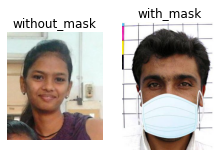

testing images



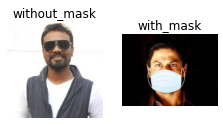

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img


train_dir='D:/陈雪/Jupyter Notebook/qimodataset2/train/'
test_dir='D:/陈雪/Jupyter Notebook/qimodataset2/test/'


print('training images\n')
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

print('testing images\n')
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(test_dir):
    img = load_img((test_dir + expression +'/'+ os.listdir(test_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

建模--VGG模型
选择了VGG16模型进行训练数据

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.4,1.5],
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=32,
                                                target_size=(224,224),
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=32, #每次喂入数据量
                                                target_size=(224,224),
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode='categorical')

Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


模型初始化

In [24]:
vgg = VGG16(weights='imagenet', include_top=False,input_shape = (224,224,3))

In [25]:
for layer in vgg.layers:
    layer.trainable = False

模型创建

In [26]:
vgg16_model = Sequential()
vgg16_model.add(vgg)
vgg16_model.add(Flatten())
vgg16_model.add(Dense( 2, activation = "softmax"))

vgg16_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


模型图：

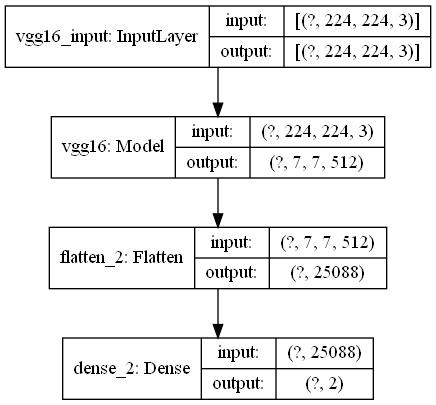

In [27]:
import pydot_ng as pydot
plot_model(vgg16_model, to_file='vgg16_diagram.jpg', show_shapes=True, show_layer_names=True)

> The Training Itself:

In [28]:
val_steps = test_set.n // test_set.batch_size
steps_per_epoch = training_set.n // training_set.batch_size

checkpoint = ModelCheckpoint("vgg16.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=8,verbose=1)

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
vgg16_model.compile(optimizer=sgd,loss = "categorical_crossentropy",metrics = ["accuracy"])

history = vgg16_model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=10,#迭代次数
                 callbacks=[checkpoint,earlystop],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=val_steps)

Epoch 1/10
30/30 [==============================] - ETA: 0s - loss: 16.2122 - accuracy: 0.5990
Epoch 00001: val_accuracy improved from -inf to 0.95982, saving model to vgg16.h5
30/30 [==============================] - 306s 10s/step - loss: 16.2122 - accuracy: 0.5990 - val_loss: 0.7122 - val_accuracy: 0.9598
Epoch 2/10
30/30 [==============================] - ETA: 0s - loss: 1.5549 - accuracy: 0.8781
Epoch 00002: val_accuracy improved from 0.95982 to 0.97768, saving model to vgg16.h5
30/30 [==============================] - 326s 11s/step - loss: 1.5549 - accuracy: 0.8781 - val_loss: 0.0945 - val_accuracy: 0.9777
Epoch 3/10
30/30 [==============================] - ETA: 0s - loss: 0.9006 - accuracy: 0.9146
Epoch 00003: val_accuracy improved from 0.97768 to 0.98661, saving model to vgg16.h5
30/30 [==============================] - 314s 10s/step - loss: 0.9006 - accuracy: 0.9146 - val_loss: 0.0648 - val_accuracy: 0.9866
Epoch 4/10
30/30 [==============================] - ETA: 0s - loss: 0.5

损失和准确率

In [29]:
def plot_res(history): #
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

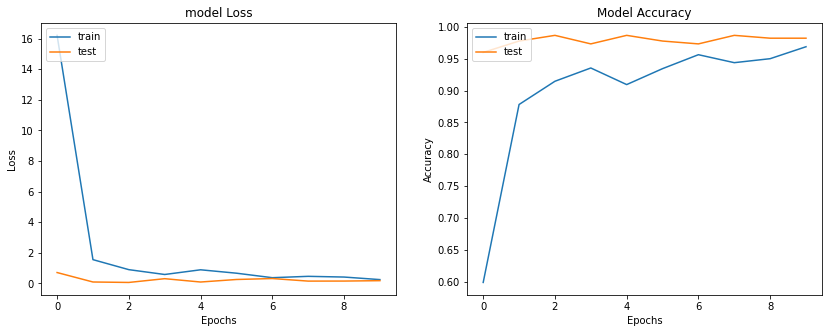

In [30]:
plot_res(history)